## CEBoost for Survival Analysis

### Introduction
`CEBoost` is a method of survival analysis that predicts hazard ratio of coxph using `xgboost` by optimizing the loss function of *Efron Approximation* + *Convex function approximated Concordance Index*.

Compared with `EfnBoost`, `CEBoost` is more capable of risk ranking. Moreover, its training phase takes less time.

Here we show you how to use CEBoost model to predict hazard ratio from scratch with the help of `libsurv`.

### Preparation

For all things going well, you would be better to get acquainted with **Survival Analysis**. Otherwise, I suggest you read the [reference](https://lifelines.readthedocs.io/en/latest/Survival%20Analysis%20intro.html).

And it may help a lot if you know a little of the Efron Approximation and Concordance Index.

### Get it started

#### Load datasets

We provide `WHAS` and `METABRIC` datasets for further studies. It can be found in module `libsurv.datasets`.

In [1]:
from libsurv.datasets import load_whas_train
from libsurv.datasets import load_whas_test

data_train = load_whas_train()
data_test = load_whas_test()

In [2]:
print(data_train.columns)

Index(['age', 'gender', 'bmi', 'chf', 'miord', 'e', 't'], dtype='object')


#### Statistics of datasets
Print statistics of survival data. The function `survival_stats` in `libsurv.datasets` provides the tool.

--------------- Survival Data Statistics ---------------
# Rows: 1310
# Columns: 5 + e + t
# Events Ratio: 42.14%
# Min Time: 1
# Max Time: 67



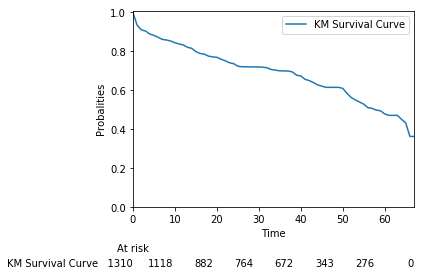

In [3]:
from libsurv.datasets import survival_stats

survival_stats(data_train, t_col="t", e_col="e", plot=True)

--------------- Survival Data Statistics ---------------
# Rows: 328
# Columns: 5 + e + t
# Events Ratio: 42.07%
# Min Time: 1
# Max Time: 67



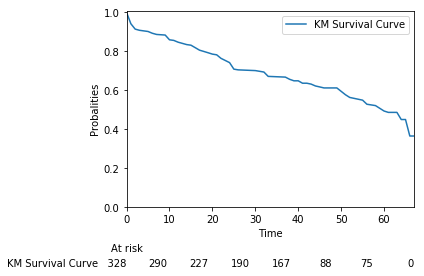

In [4]:
survival_stats(data_test, t_col="t", e_col="e", plot=True)

#### Survival data transfrom

The column of time and status in survival data will be packed into an new column as label in the transformed data.

The transformed survival data contains an new label, where negtive values are considered as right censored, and positive values are considered as event occurrence.

**NOTE**: In `libsurv`, survival data must be transformed via `libsurv.datasets.survival_df`. But for `xgboost` model, the type of data must be `DMatrix`, so we **have two ways to achive this as listed below**.

```python
##############################################################################
# method 1:
from libsurv.datasets import survival_dmat

surv_train = survival_dmat(data_train, t_col="t", e_col="e", label_col="Y")
surv_test = survival_dmat(data_test, t_col="t", e_col="e", label_col="Y")

##############################################################################

##############################################################################
# method 2
from libsurv.datasets import survival_df
from xgboost import DMatrix


data_train = survival_df(data_train, t_col="t", e_col="e", label_col="Y")
data_test = survival_df(data_test, t_col="t", e_col="e", label_col="Y")

x_cols = list(data_train.columns)[:-1]

surv_train = DMatrix(data_train[x_cols], label=data_train['Y'].values)
surv_test = DMatrix(data_test[x_cols], label=data_test['Y'].values)
################################################################################
```

In [5]:
from libsurv.datasets import survival_dmat

# via survival_dmat function
surv_train = survival_dmat(data_train, t_col="t", e_col="e", label_col="Y")
surv_test = survival_dmat(data_test, t_col="t", e_col="e", label_col="Y")

#### Model initialization

Here we start to initialize a CEBoost model.

In [6]:
from libsurv import CEBoost

params = {
    'eta':0.3,
    'max_depth':6, 
    'min_child_weight': 8, 
    'subsample': 0.9,
    'colsample_bytree': 0.5,
    'gamma': 0.20,
    'lambda': 0,
}

model = CEBoost(params, loss_alpha=0.5)

#### Model training

Training model and plotting the learning curve.

[0]	train-rmse:41.3776	test-rmse:41.5729	train-ce_loss:3.17608	test-ce_loss:2.47359
[10]	train-rmse:40.8777	test-rmse:41.0733	train-ce_loss:2.84689	test-ce_loss:2.02997
[20]	train-rmse:40.6771	test-rmse:40.8913	train-ce_loss:2.74628	test-ce_loss:1.80521
[30]	train-rmse:40.5887	test-rmse:40.8106	train-ce_loss:2.69794	test-ce_loss:1.72353
[40]	train-rmse:40.5022	test-rmse:40.7209	train-ce_loss:2.65815	test-ce_loss:1.623
[50]	train-rmse:40.3883	test-rmse:40.608	train-ce_loss:2.61717	test-ce_loss:1.48841
[60]	train-rmse:40.3215	test-rmse:40.5512	train-ce_loss:2.58903	test-ce_loss:1.4489
[70]	train-rmse:40.2704	test-rmse:40.5148	train-ce_loss:2.5639	test-ce_loss:1.43544
[80]	train-rmse:40.2027	test-rmse:40.4461	train-ce_loss:2.54574	test-ce_loss:1.40718
[90]	train-rmse:40.1496	test-rmse:40.3874	train-ce_loss:2.52343	test-ce_loss:1.32903
[99]	train-rmse:40.106	test-rmse:40.3487	train-ce_loss:2.50482	test-ce_loss:1.26737


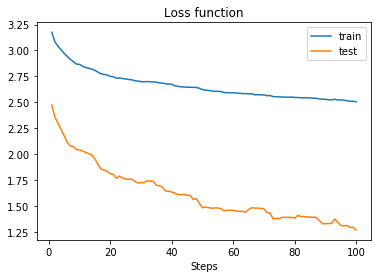

In [7]:
eval_result = model.train(
    surv_train,
    num_rounds=100,
    skip_rounds=10,
    evals=[(surv_train, 'train'), (surv_test, 'test')],
    plot=True
)

#### Prediction and Evaluation

Now we use the trained model to make prediction or evaluate model performance.

Give the prediction of CEBoost model with:
- `model.predict`: Hazard Ratio of coxph
- `model.predict_survival_function`: survival function transformed from hazard ratio

Prediction of hazard ratio: [0.1296317  8.277655   0.33950415 0.43014628 3.3611019 ]


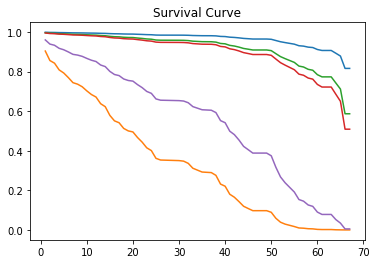

In [8]:
# select the first 5 samples
surv_data_now = surv_test.slice([i for i in range(5)])

# Predict Hazard Ratio
print("Prediction of hazard ratio:", model.predict(surv_data_now, output_margin=False))

# Predict Survival Function
result_survf = model.predict_survival_function(surv_data_now, plot=True)

In [9]:
result_survf

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,58.0,59.0,60.0,61.0,62.0,63.0,64.0,65.0,66.0,67.0
0,0.998411,0.997559,0.997313,0.996672,0.996365,0.995901,0.995374,0.995216,0.994936,0.994482,...,0.923224,0.921167,0.911332,0.906372,0.906372,0.906372,0.892401,0.878117,0.815759,0.815759
1,0.903451,0.855530,0.842141,0.808288,0.792525,0.769271,0.743715,0.736204,0.723113,0.702353,...,0.006091,0.005282,0.002662,0.001878,0.001878,0.001878,0.000697,0.000249,0.000002,0.000002
2,0.995844,0.993621,0.992978,0.991309,0.990508,0.989299,0.987929,0.987518,0.986792,0.985613,...,0.811223,0.806497,0.784141,0.773012,0.773012,0.773012,0.742193,0.711482,0.586652,0.586652
3,0.994738,0.991925,0.991112,0.989001,0.987989,0.986462,0.984731,0.984212,0.983295,0.981807,...,0.767153,0.761495,0.734850,0.721662,0.721662,0.721662,0.685405,0.649672,0.508794,0.508794
4,0.959611,0.938609,0.932616,0.917208,0.909902,0.898966,0.886717,0.883070,0.876660,0.866352,...,0.126033,0.118950,0.090053,0.078170,0.078170,0.078170,0.052253,0.034389,0.005093,0.005093


In [10]:
# evaluate model performance 
print("td-CI on training set:", model.evals(surv_train))
print("td-CI on test set:", model.evals(surv_test))

td-CI on training set: 0.8888220294679342
td-CI on test set: 0.8208863983698421


#### save model

In [11]:
model.save_model("CEBoost.model")